In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [3]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")


In [4]:
# Fill missing values
train["Age"].fillna(train["Age"].median(), inplace=True)
test["Age"].fillna(train["Age"].median(), inplace=True)

test["Fare"].fillna(test["Fare"].median(), inplace=True)
train["Embarked"].fillna(train["Embarked"].mode()[0], inplace=True)
test["Embarked"].fillna(test["Embarked"].mode()[0], inplace=True)

# Family size
train["FamilySize"] = train["SibSp"] + train["Parch"] + 1
test["FamilySize"] = test["SibSp"] + test["Parch"] + 1

# IsAlone
train["IsAlone"] = (train["FamilySize"] == 1).astype(int)
test["IsAlone"] = (test["FamilySize"] == 1).astype(int)

# Title from Name
train["Title"] = train["Name"].str.extract(" ([A-Za-z]+)\.", expand=False)
test["Title"] = test["Name"].str.extract(" ([A-Za-z]+)\.", expand=False)

for df in [train, test]:
    df["Title"] = df["Title"].replace(['Mlle', 'Ms'], 'Miss')
    df["Title"] = df["Title"].replace('Mme', 'Mrs')
    df["Title"] = df["Title"].replace(['Lady', 'Countess','Capt','Col',
                                       'Don','Dr','Major','Rev','Sir',
                                       'Jonkheer','Dona'], 'Rare')


/tmp/ipykernel_13/3603717901.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train["Age"].fillna(train["Age"].median(), inplace=True)
/tmp/ipykernel_13/3603717901.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

In [5]:
features = [
    "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare",
    "Embarked", "FamilySize", "IsAlone", "Title"
]

target = "Survived"


In [6]:
cat_features = ["Sex", "Embarked", "Title"]
X = train[features]
y = train[target]
X_test_final = test[features]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [7]:
model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=4,
    random_state=42,
    cat_features=cat_features,
    verbose=0
)

model.fit(X_train, y_train, cat_features=cat_features)


Validation Accuracy: 0.8212290502793296

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.85       105
           1       0.81      0.74      0.77        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



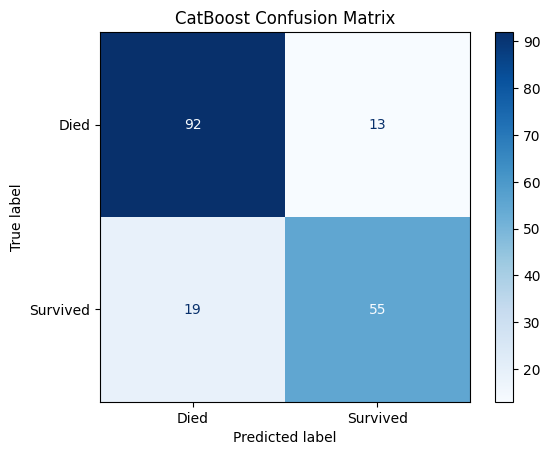

In [8]:
val_preds = model.predict(X_val)

print("Validation Accuracy:", accuracy_score(y_val, val_preds))
print("\nClassification Report:\n", classification_report(y_val, val_preds))

# Confusion Matrix
cm = confusion_matrix(y_val, val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Died", "Survived"])
disp.plot(cmap=plt.cm.Blues)
plt.title("CatBoost Confusion Matrix")
plt.show()


In [9]:
final_preds = model.predict(X_test_final)

submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": final_preds.astype(int)
})

submission.to_csv("submission.csv", index=False)
print("Submission file created!")


Submission file created!
